<a href="https://colab.research.google.com/github/Nathan-Levy/Traffic-Flow-Prediction-in-Urban-Areas/blob/main/Hamburg_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras

In [ ]:
man_long_lat = pd.read_csv('London_long_lat.csv')

In [ ]:
print(max(man_long_lat['lat']))
print(min(man_long_lat['lat']))
print(max(man_long_lat['long']))
print(min(man_long_lat['long']))

51.5546463
51.460225
0.034174
-0.214881


In [ ]:
hamburg_data = pd.read_csv('utd19_part_32.csv')

In [ ]:
filtered_data = hamburg_data[hamburg_data['detid'] == 'K34D3.1']
print(filtered_data)

               day  interval    detid  flow       occ  error     city  speed
347475  2016-08-27         0  K34D3.1    80  0.036667    1.0  hamburg    NaN
347476  2016-08-27       180  K34D3.1   120  0.043333    1.0  hamburg    NaN
347477  2016-08-27       360  K34D3.1    60  0.060000    1.0  hamburg    NaN
347478  2016-08-27       540  K34D3.1    40  0.110000    1.0  hamburg    NaN
347479  2016-08-27       720  K34D3.1    20  0.013333    1.0  hamburg    NaN
...            ...       ...      ...   ...       ...    ...      ...    ...
397559  2016-12-09     38160  K34D3.1    40  0.476667    1.0  hamburg    NaN
397560  2016-12-09     38340  K34D3.1    80  0.033333    1.0  hamburg    NaN
397561  2016-12-09     38520  K34D3.1   120  0.560000    1.0  hamburg    NaN
397562  2016-12-09     38700  K34D3.1   160  0.556667    1.0  hamburg    NaN
397563  2016-12-09     38880  K34D3.1   100  0.836667    1.0  hamburg    NaN

[50089 rows x 8 columns]


In [ ]:
filtered_data['day'] = pd.to_datetime(filtered_data['day'])

filtered_data['datetime'] = filtered_data['day'] + pd.to_timedelta(filtered_data['interval'], unit='s')

filtered_data.set_index("datetime", inplace=True)

# Keep only the relevant column
time_flow = filtered_data[['flow']]

print(time_flow)

                     flow
datetime                 
2016-08-27 00:00:00    80
2016-08-27 00:03:00   120
2016-08-27 00:06:00    60
2016-08-27 00:09:00    40
2016-08-27 00:12:00    20
...                   ...
2016-12-09 10:36:00    40
2016-12-09 10:39:00    80
2016-12-09 10:42:00   120
2016-12-09 10:45:00   160
2016-12-09 10:48:00   100

[50089 rows x 1 columns]


<ipython-input-14-45bd09417db5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['day'] = pd.to_datetime(filtered_data['day'])
<ipython-input-14-45bd09417db5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['datetime'] = filtered_data['day'] + pd.to_timedelta(filtered_data['interval'], unit='s')


In [ ]:
# Normalise
scaler = MinMaxScaler()
flow_normalised = scaler.fit_transform(time_flow)

In [ ]:
# Train and validation split

train = len(flow_normalised)*0.8
X_train, X_val, = flow_normalised[:int(train)], flow_normalised[int(train):]

In [ ]:
def create_dataset(dataset, look_back):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 12
X_train, y_train = create_dataset(X_train, look_back)
X_val, y_val = create_dataset(X_val, look_back)

[[0.14285714 0.21428571 0.10714286 0.07142857 0.03571429 0.03571429
  0.25       0.21428571 0.03571429 0.25       0.21428571 0.10714286]
 [0.21428571 0.10714286 0.07142857 0.03571429 0.03571429 0.25
  0.21428571 0.03571429 0.25       0.21428571 0.10714286 0.07142857]
 [0.10714286 0.07142857 0.03571429 0.03571429 0.25       0.21428571
  0.03571429 0.25       0.21428571 0.10714286 0.07142857 0.07142857]
 [0.07142857 0.03571429 0.03571429 0.25       0.21428571 0.03571429
  0.25       0.21428571 0.10714286 0.07142857 0.07142857 0.14285714]
 [0.03571429 0.03571429 0.25       0.21428571 0.03571429 0.25
  0.21428571 0.10714286 0.07142857 0.07142857 0.14285714 0.10714286]]


In [ ]:
# [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

In [ ]:
input_layer = keras.layers.Input(shape=(look_back, 1))
encoded = keras.layers.LSTM(64, activation='relu', return_sequences=True)(input_layer)
encoded = keras.layers.LSTM(32, activation='relu', return_sequences=False)(encoded)

# Decoder
decoded = keras.layers.Dense(64, activation='relu')(encoded)
decoded = keras.layers.Dense(look_back, activation='linear')(decoded)

# Autoencoder Model
autoencoder = keras.models.Model(inputs=input_layer, outputs=decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 12, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 12, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,204 (125.80 KB)

 Trainable params: 32,204 (125.80 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=20, validation_data=[X_val, X_val])

Epoch 1/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - loss: 0.0073 - val_loss: 0.0051
Epoch 2/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 3/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 4/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - loss: 0.0010 - val_loss: 7.9302e-04
Epoch 6/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - loss: 6.1559e-04 - val_loss: 6.9482e-04
Epoch 7/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 5.6189e-04 - val_loss: 7.1274e-04
Epoch 8/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 4.8727e-04 - val_loss: 1.0480e-04
Epoch 9/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 9.2706e-05 - val_loss: 5.5245e-05
Epoch 10/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 6.2973e-05 - val_loss: 4.3617e-05
Epoch 11/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/ste

In [ ]:
# Extract the encoder model
encoder = keras.models.Model(inputs=input_layer, outputs=encoded)

# Generate the encoded features
encoded_features = encoder.predict(X_train)
encoded_features_val = encoder.predict(X_val)

1252/1252 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [ ]:
# Define the prediction model
prediction_model = keras.models.Sequential()
prediction_model.add(keras.layers.Dense(16, activation='relu', input_dim=encoded_features.shape[1]))
prediction_model.add(keras.layers.Dense(8, activation='relu'))
prediction_model.add(keras.layers.Dense(1, activation='linear'))

# Compile the prediction model
prediction_model.compile(optimizer='adam', loss='mse')

# Train the prediction model
prediction_model.fit(encoded_features, y_train, epochs=20, validation_data=(encoded_features_val, y_val))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1252/1252 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0107 - val_loss: 0.0085
Epoch 2/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0070 - val_loss: 0.0084
Epoch 3/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0072 - val_loss: 0.0083
Epoch 4/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0069 - val_loss: 0.0083
Epoch 5/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0070 - val_loss: 0.0082
Epoch 6/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0069 - val_loss: 0.0082
Epoch 7/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0070 - val_loss: 0.0082
Epoch 8/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0069 - val_loss: 0.0082
Epoch 9/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0070 - val_loss: 0.0082
Epoch 10/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0069 - val_loss: 0.0082
Epoch 11/20
1252/1252 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0069 - val_loss: 0.0082
Epoch 12/20
1252/1252 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# Use the prediction model to make predictions
y_pred = prediction_model.predict(encoded_features_val)

# Inverse transform the predictions to the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


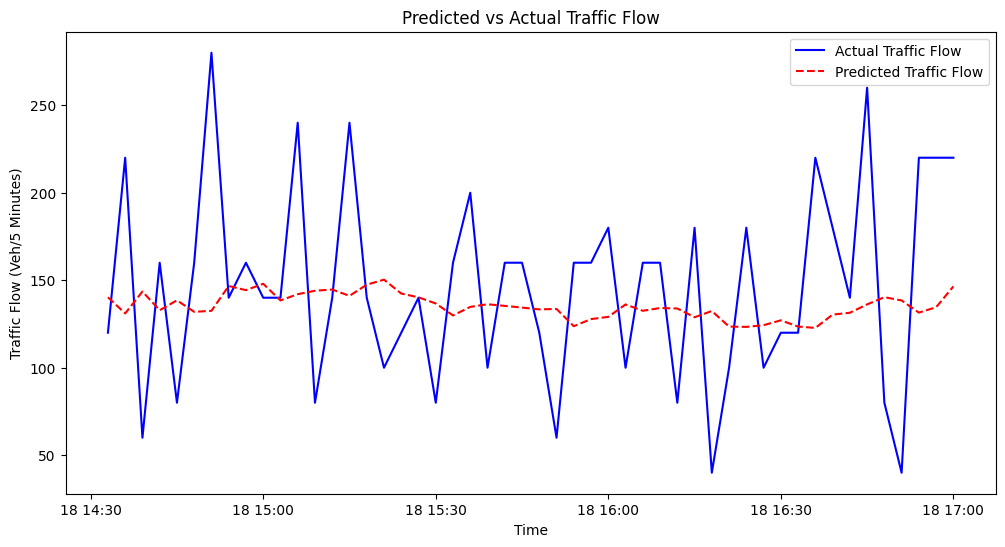

In [ ]:
# timestamps from validation set.
timestamps = time_flow.index[-len(y_val):]

import matplotlib.pyplot as plt

# Rescale the predicted values and actual values to their original scale
y_test_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(timestamps[:50], y_test_rescaled[:50], label='Actual Traffic Flow', color='blue')
plt.plot(timestamps[:50], y_pred_rescaled[:50], label='Predicted Traffic Flow', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Traffic Flow (Veh/3 Minutes)')
plt.title('Predicted vs Actual Traffic Flow')
plt.legend()
plt.show()


In [ ]:
y_test_rescaled[:10]


array([[120.],
       [220.],
       [ 60.],
       [160.],
       [ 80.],
       [160.],
       [280.],
       [140.],
       [160.],
       [140.]])

In [ ]:
y_pred_rescaled[:10]

array([[140.25421],
       [131.02573],
       [143.5249 ],
       [132.84918],
       [138.51544],
       [131.94485],
       [132.5008 ],
       [146.70747],
       [144.32356],
       [147.96237]], dtype=float32)